In [2]:
import pandas as pd

df_articles = pd.read_csv(r"C:\Users\Grant Beardall\Downloads\shared_articles.csv")
df_interactions = pd.read_csv(r"C:\Users\Grant Beardall\Downloads\users_interactions.csv")

df_articles.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [3]:
df_interactions.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


In [4]:
# Keep only meaningful interaction types (no CONTENT SHARED)
valid_events = ['VIEW', 'LIKE', 'FOLLOW', 'BOOKMARK', 'COMMENT CREATED']
df_interactions = df_interactions[df_interactions['eventType'].isin(valid_events)]

# Map eventType to numeric scores
event_type_map = {
    'VIEW': 1,
    'LIKE': 2,
    'FOLLOW': 3,
    'BOOKMARK': 4,
    'COMMENT CREATED': 5
}
df_interactions['interaction_score'] = df_interactions['eventType'].map(event_type_map)


In [5]:
print(df_interactions.columns)


Index(['timestamp', 'eventType', 'contentId', 'personId', 'sessionId',
       'userAgent', 'userRegion', 'userCountry', 'interaction_score'],
      dtype='object')


In [6]:
# Cleaned DataFrame with correct column names
user_article_ratings = df_interactions[['personId', 'contentId', 'interaction_score']]
user_article_ratings.head()


,personId,contentId,interaction_score
0,-8845298781299428018,-3499919498720038879,1
1,-1032019229384696495,8890720798209849691,1
2,-1130272294246983140,310515487419366995,1
3,344280948527967603,310515487419366995,3
4,-445337111692715325,-7820640624231356730,1


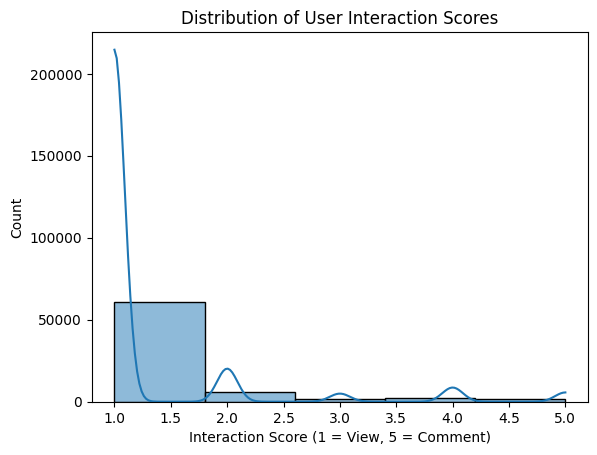

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=user_article_ratings, x='interaction_score', kde=True, bins=5)
plt.title('Distribution of User Interaction Scores')
plt.xlabel('Interaction Score (1 = View, 5 = Comment)')
plt.ylabel('Count')
plt.show()


In [8]:
import numpy as np

from scipy.sparse import csr_matrix

num_users = user_article_ratings['personId'].nunique()
num_articles = user_article_ratings['contentId'].nunique()

user_mapper = dict(zip(np.unique(user_article_ratings['personId']), list(range(num_users))))
article_mapper = dict(zip(np.unique(user_article_ratings['contentId']), list(range(num_articles))))

user_inv_mapper = dict(zip(list(range(num_users)), np.unique(user_article_ratings['personId'])))
article_inv_mapper = dict(zip(list(range(num_articles)), np.unique(user_article_ratings['contentId'])))

user_index = [user_mapper[i] for i in user_article_ratings['personId']]
article_index = [article_mapper[i] for i in user_article_ratings['contentId']]

X = csr_matrix((user_article_ratings['interaction_score'], (article_index, user_index)), shape=(num_articles, num_users))
X.shape


(2987, 1895)

In [9]:
from sklearn.neighbors import NearestNeighbors

def recommend_article(article_id, X, article_mapper, article_inv_mapper, k=5, metric='cosine', messages=True):
    rec_ids = []  # List to store recommended article IDs

    # Convert article ID to matrix index
    article_index = article_mapper.get(article_id)
    if article_index is None:
        print("Article ID not found.")
        return [], []

    # Get article vector (row of the matrix)
    article_vector = X[article_index]

    # Fit KNN model on article-user matrix
    knn = NearestNeighbors(n_neighbors=k+1, metric=metric, algorithm='brute')
    knn.fit(X)

    # Get k nearest neighbors
    distances, indices = knn.kneighbors(article_vector.reshape(1, -1))

    # Remove the first one (it's the article itself)
    rec_indices = indices.flatten()[1:]
    rec_distances = distances.flatten()[1:]

    # Map back to original article IDs
    rec_ids = [article_inv_mapper[idx] for idx in rec_indices]

    if messages:
        print(f"Recommended article IDs: {rec_ids}")
        print(f"Similarity distances: {rec_distances}")

    return rec_ids, rec_distances


In [10]:
# Step 1: Pick a sample article ID
sample_article_id = user_article_ratings['contentId'].sample(1).values[0]

# Step 2: Get the title of the original article
sample_article_title = df_articles[df_articles['contentId'] == sample_article_id]['title'].values[0]

print(f"Recommendations based on this article:\n\"{sample_article_title}\"\n")

# Step 3: Generate recommendations
recommended_ids, distances = recommend_article(
    article_id=sample_article_id,
    X=X,
    article_mapper=article_mapper,
    article_inv_mapper=article_inv_mapper,
    k=15,  # Fetch more than you need in case of duplicates
    metric='cosine',
    messages=False
)

# Step 4: Get titles of recommended articles
recommended_articles = df_articles[df_articles['contentId'].isin(recommended_ids)][['contentId', 'title']]

# Step 5: Remove articles with the same title as the sample article
recommended_articles = recommended_articles[recommended_articles['title'] != sample_article_title]

# Step 6: Drop duplicate titles (keeping first appearance)
recommended_articles = recommended_articles.drop_duplicates(subset='title')

# Step 7: Limit to top 5 unique titles
recommended_articles = recommended_articles.head(5)

# Step 8: Show clean output
print("📰 You might also like:\n")
for i, row in recommended_articles.iterrows():
    print(f"{i+1}. {row['title']}")


Recommendations based on this article:
"Mesmo sem apoio, Parada LGBT de Campinas arrasta multidão pelas ruas"

📰 You might also like:

477. Finally, CSS In JavaScript! Meet CSSX - Smashing Magazine
873. Para rebater Estatuto da Família, campanha muda significado de 'família' no Dicionário Houaiss
999. Para entender o Dia Internacional contra a Homofobia
1153. Netflix emociona com vídeo destacando personagens LGBT
1484. YouTube chama seus criadores de conteúdo para a campanha mundial #OrgulhoDeSer


In [14]:
import pandas as pd
import random

# How many recommendations per article?
k = 5

# How many articles to randomly sample?
sample_size = 100

# Optional: set seed for reproducibility
random.seed(42)

# Get all article IDs from df_articles
all_article_ids = df_articles['contentId'].unique().tolist()

# Randomly sample article IDs
sampled_article_ids = random.sample(all_article_ids, sample_size)

print(f"🧠 Generating recommendations for {len(sampled_article_ids)} randomly selected articles...")

# Set up column headers
columns = ['Article ID', 'If you read']
for i in range(1, k + 1):
    columns.append(f'Rec ID {i}')
    columns.append(f'Recommendation {i}')

# Create empty DataFrame
df_recommendations = pd.DataFrame(columns=columns)

# Generate recommendations for each sampled article
for article_id in sampled_article_ids:
    try:
        # Get recommendations
        rec_ids, _ = recommend_article(
            article_id=article_id,
            X=X,
            article_mapper=article_mapper,
            article_inv_mapper=article_inv_mapper,
            k=k + 1,
            metric='cosine',
            messages=False
        )

        # Remove self if in recs
        rec_ids = [rid for rid in rec_ids if rid != article_id][:k]

        # Get original title
        original_title = df_articles[df_articles['contentId'] == article_id]['title'].values[0]

        # Build row
        row = [article_id, original_title]
        for rid in rec_ids:
            rec_title = df_articles[df_articles['contentId'] == rid]['title'].values[0]
            row.extend([rid, rec_title])

        # Pad if fewer than k
        while len(row) < 2 + k * 2:
            row.extend([None, None])

        # Add row to DataFrame
        df_recommendations.loc[len(df_recommendations)] = row

    except Exception as e:
        print(f"⚠️ Skipped article {article_id} due to error: {e}")

# Export to CSV
df_recommendations.to_csv('sampled_article_recommendations.csv', index=False)
print("✅ Saved to 'sampled_article_recommendations.csv'")


🧠 Generating recommendations for 100 randomly selected articles...
Article ID not found.
Article ID not found.
✅ Saved to 'sampled_article_recommendations.csv'
